In [16]:
import numpy as np
from pulp import *
import random
import matplotlib.pyplot as plt
import pandas as pd


STATUS: Infeasible

Optymalne rozwiązanie:
Alt10_Utility = 0.1000
Alt11_Utility = 0.1000
Alt12_Utility = 0.1000
Alt13_Utility = 0.1000
Alt14_Utility = 0.1000
Alt15_Utility = 0.2000
Alt16_Utility = 0.1000
Alt17_Utility = 0.1000
Alt18_Utility = 0.1000
Alt19_Utility = 0.1000
Alt1_Utility  = 0.1000
Alt20_Utility = 0.1000
Alt21_Utility = 0.1000
Alt22_Utility = 0.2000
Alt23_Utility = 0.1000
Alt24_Utility = 0.2000
Alt25_Utility = 0.0000
Alt26_Utility = 0.0000
Alt27_Utility = 0.0000
Alt2_Utility  = 0.1000
Alt3_Utility  = 0.1000
Alt4_Utility  = 0.1000
Alt5_Utility  = 0.1000
Alt6_Utility  = 0.1000
Alt7_Utility  = 0.1000
Alt8_Utility  = 0.1000
Alt9_Utility  = 0.1000
C1_0.32       = 0.1000
C1_0.34       = 0.0000
C1_0.35       = 0.0000
C1_0.4        = 0.0000
C1_0.44       = 0.0000
C1_0.45       = 0.0000
C1_0.48       = 0.0000
C1_0.59       = 0.0000
C1_0.6        = 0.0000
C1_0.61       = 0.0000
C1_0.62       = 0.0000
C1_0.64       = 0.0000
C1_0.65       = 0.0000
C1_0.66       = 0.0000
C1_0.68      

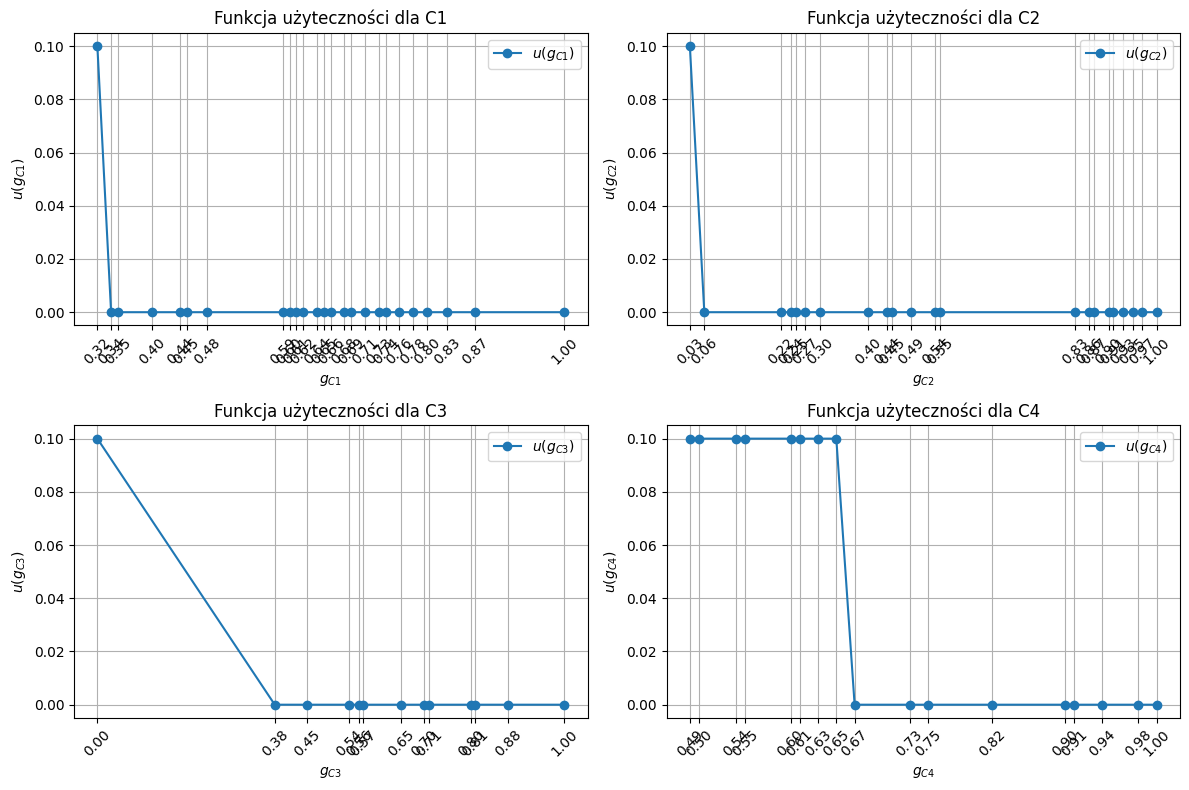

In [27]:
# Wczytanie danych
file_path = "../data.csv"
data = pd.read_csv(file_path, index_col=0)
criteria = list(data.columns)

# Tworzenie problemu optymalizacyjnego
prob = LpProblem("UTA_Method", LpMaximize)

# Tworzenie zmiennych decyzyjnych dla każdego kryterium
criteria_vars = {
    c: {val: LpVariable(f"{c}_{val}", lowBound=0, upBound=1) for val in sorted(data[c].unique(), reverse=True)} for c in
    criteria} # reverse=True - bo są typu koszt

# Ograniczenia monotoniczności (odwrotne - bo koszty)
for c, vars_dict in criteria_vars.items():
    sorted_values = sorted(vars_dict.keys(), reverse=True)
    for i in range(len(sorted_values) - 1):
        prob += vars_dict[sorted_values[i]] >= vars_dict[sorted_values[i + 1]], f"Monotonicity_{c}_{i}"

# Ograniczenia normalizacji (0 -> highest, koszta)
for c in criteria:
    prob += criteria_vars[c][max(data[c])] == 0, f"Normalize_{c}_Highest"
prob += lpSum([criteria_vars[c][min(data[c])] for c in criteria]) == 1, "Normalize_Criteria_Sum"

# Ograniczenia wag kryteriów (min 0.1, max 0.5)
for c in criteria:
    prob += criteria_vars[c][min(data[c])] >= 0.1, f"Min_Weight_{c}"
    prob += criteria_vars[c][min(data[c])] <= 0.5, f"Max_Weight_{c}"

# Tworzenie zmiennych użytkowych dla alternatyw
table_utilities = {}
for idx, row in data.iterrows():
    utility_var = LpVariable(f"Alt{idx}_Utility", lowBound=0)
    table_utilities[idx] = utility_var
    prob += utility_var == lpSum([criteria_vars[c][row[c]] for c in criteria]), f"Utility_Alt{idx}"

# Definiowanie preferencji i optymalizacji epsilon
epsilon = LpVariable("epsilon", lowBound=0)
prob += table_utilities[14] >= table_utilities[11] + epsilon, "Pref_14_11" # ta jest od Oskara (R2 > R1)
prob += table_utilities[2] >= table_utilities[25] + epsilon, "Pref_2_25" # ta jest od Kota  (R1 > R3)
# todo -> dodać jeszcze 3 jakieś pary żeby mieć do referencyjnych
# Ponieważ obydwoje mamy Czwartą grupę informacji preferencyjnej,
# wybieramy przykłady które ją spełniają przede wszystkim. R2 > R1 > R3
prob += table_utilities[11] >= table_utilities[17] + epsilon, "Pref_11_17"  # R2 >> R3
# ten przykład daje nam kontynuację 14 > 11 > 17 (mają te samą grupę finansowania, ale różne lokacje)

# prob += table_utilities[4] >= table_utilities[1] + epsilon, "Pref_4_1"   # R2 > R1
# prob += table_utilities[1] >= table_utilities[7] + epsilon, "Pref_1_7"  # R1 > R3
# wykomentowane, bo ma być 5 par wariantów referencyjnych,
# oraz 2 grupy preferencji - więc trzeba dodać coś z drugiej grupy preferencji

# przykłady "remisu" lokalizacji, różniące sposobem finansowania (zakładamy, że F1 > F2 oraz F1 > F3)
prob += table_utilities[4] >= table_utilities[5] + epsilon, "Pref_4_5"   # F1 > F2
prob += table_utilities[4] >= table_utilities[6] + epsilon, "Pref_4_6"   # F1 > F3


# Maksymalizacja epsilon
prob += epsilon, "Maximize_Epsilon"

# Rozwiązanie problemu
prob.solve()

# Wyświetlenie wyników
print(f"\n{'='*30}\nSTATUS: {LpStatus[prob.status]}\n{'='*30}\n")
print("Optymalne rozwiązanie:")
max_var_length = max(len(var.name) for var in prob.variables())
for var in prob.variables():
    print(f"{var.name.ljust(max_var_length)} = {value(var):.4f}")
print("\nWartość funkcji celu:", f"{value(prob.objective):.4f}\n")

# Generowanie wykresów dla każdego kryterium
plt.figure(figsize=(12, 8))
for i, c in enumerate(criteria, 1):
    values = sorted(criteria_vars[c].keys(), reverse=True) # sort reverse? czy nie?
    solver_values = [value(criteria_vars[c][v]) for v in values]

    plt.subplot(2, 2, i)
    plt.plot(values, solver_values, marker='o', linestyle='-', label=f'$u(g_{{{c}}})$')
    plt.xlabel(f'$g_{{{c}}}$')
    plt.ylabel(f'$u(g_{{{c}}})$')
    plt.title(f'Funkcja użyteczności dla {c}')
    plt.xticks(values, rotation=45)
    plt.grid(True)
    plt.legend()

plt.tight_layout()
plt.show()
